# **Umair Ahmad**
# **21i-2081**
# Deep Learning Assignment 1

# Part 2 Data Training

# Importing libraries

In [17]:
from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from torch.utils.data.sampler import WeightedRandomSampler
plt.ion()   # interactive mode
import pandas as pd

# Transforming the Data,  Creating Sampler, Creating Data Loader

In [18]:
#Transforming the Data
data_transforms = {
    'Images': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.4795, 0.4467, 0.3896],[0.2200, 0.2149, 0.2130]) #Updated values after executing the next cell
    ])}

data_dir = '/content/drive/MyDrive/NewImageNetDogs'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),data_transforms[x]) for x in ['Images']}
class_names = image_datasets['Images'].classes


#the class used to handle the oversampling or undersampling of the data for unbalanced classes
df=pd.read_csv("data.csv")
class_counts =df["Updated_count"]
num_samples = sum(class_counts)
labels,i =[],0

for x in class_counts:
  for y in range(0,x):
    labels.append(i)
  i=i+1
class_weights = [num_samples/class_counts[i] for i in range(len(class_counts))]
counts = np.bincount(labels)
labels_weights = 1. / counts
samples_weight = labels_weights[labels]
sampler = WeightedRandomSampler(torch.DoubleTensor(samples_weight), int(num_samples), replacement=True)



# Data Loading
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, num_workers=2, sampler = sampler) for x in ['Images']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['Images']}
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Customized values of RGB means and standard deviations for my own data

In [ ]:
#Calculate the customized values of RGB means and standard deviations for my own data and plug them into the transform component of the dataset, don't use the ones given in the example 
def get_mean_and_std(dataloader):
  nimages = 0
  mean = 0.
  std = 0.
  for batch, _ in dataloader:
      # Rearrange batch to be the shape of [B, C, W * H]
      batch = batch.view(batch.size(0), batch.size(1), -1)
      # Update total number of images
      nimages += batch.size(0)
      # Compute mean and std here
      mean += batch.mean(2).sum(0) 
      std += batch.std(2).sum(0)
  # Final step
  mean /= nimages
  std /= nimages
  return mean, std

#mean,std=get_mean_and_std(dataloaders['Images'])
#print(mean)
#print(std)

tensor([0.4795, 0.4467, 0.3896])
tensor([0.2200, 0.2149, 0.2130])


# Visualization of Random Data Points

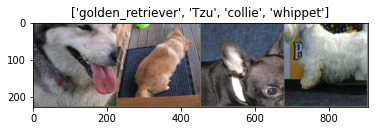

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['Images']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

# Function train_model will return the tranined model after computing every epoch

In [ ]:
#Removed all mention of train and val/test phases from the code and data loaders and datasets. We will be using the code only in training phase
#Removed the lr_scheduler from the code
def train_model(model, criterion, optimizer, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        model.train()  # Set model to training mode
        running_loss = 0.0
        running_corrects = 0

            # Iterate over data.
        for inputs, labels in dataloaders['Images']:
          inputs = inputs.to(device)
          labels = labels.to(device)

          # zero the parameter gradients
          optimizer.zero_grad()

          # forward
          # track history if only in train
          with torch.set_grad_enabled(True):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

          # statistics
          running_loss += loss.item() * inputs.size(0)
          running_corrects += torch.sum(preds == labels.data)


        epoch_loss = running_loss / dataset_sizes["Images"]
        epoch_acc = running_corrects.double() / dataset_sizes["Images"]

        print('Loss: {:.4f} Acc: {:.4f}'.format( epoch_loss, epoch_acc))

          # deep copy the model
        if epoch_acc > best_acc:
          best_acc = epoch_acc
          best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

# Loading Pretrainined Resnet and fine tuning it on my own dataset with 120 classes prediction

In [ ]:
#loading Pretrainined Resnet
model_conv = torchvision.models.resnet18(pretrained=True)
#freezing the all layers of pretranied model except the last one
for param in model_conv.parameters():
    param.requires_grad = False

#creating the last fully connected layer
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 120) #One change the number of output neurons to the correct number for your classification example [1 mark] 
model_conv = model_conv.to(device)
# defining Loss function
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
# using AdaGrad as a optimization function
optimizer_ft = optim.Adagrad(model_conv.fc.parameters(), lr=0.01, lr_decay=0, weight_decay=0, initial_accumulator_value=0, eps=1e-10) #Change the optimizer to Adagrad 



# Traning Started and model saved 

In [ ]:
model_conv = train_model(model_conv, criterion, optimizer_ft, num_epochs=50)
torch.save(model_conv.state_dict(), '/content/drive/MyDrive/NewImageNetDogs/MyModel')

Epoch 0/49
----------
Loss: 2.8901 Acc: 0.3573
Epoch 1/49
----------
Loss: 2.2653 Acc: 0.4716
Epoch 2/49
----------
Loss: 2.0971 Acc: 0.5046
Epoch 3/49
----------
Loss: 1.9871 Acc: 0.5268
Epoch 4/49
----------
Loss: 1.9429 Acc: 0.5327
Epoch 5/49
----------
Loss: 1.9078 Acc: 0.5354
Epoch 6/49
----------
Loss: 1.8590 Acc: 0.5494
Epoch 7/49
----------
Loss: 1.8687 Acc: 0.5460
Epoch 8/49
----------
Loss: 1.8311 Acc: 0.5520
Epoch 9/49
----------
Loss: 1.7830 Acc: 0.5633
Epoch 10/49
----------
Loss: 1.7787 Acc: 0.5608
Epoch 11/49
----------
Loss: 1.7670 Acc: 0.5641
Epoch 12/49
----------
Loss: 1.7624 Acc: 0.5623
Epoch 13/49
----------
Loss: 1.7323 Acc: 0.5725
Epoch 14/49
----------
Loss: 1.7390 Acc: 0.5673
Epoch 15/49
----------
Loss: 1.7321 Acc: 0.5713
Epoch 16/49
----------
Loss: 1.7031 Acc: 0.5772
Epoch 17/49
----------
Loss: 1.6767 Acc: 0.5777
Epoch 18/49
----------
Loss: 1.6867 Acc: 0.5791
Epoch 19/49
----------
Loss: 1.7054 Acc: 0.5766
Epoch 20/49
----------
Loss: 1.6925 Acc: 0.5749
Ep

# **Results during training**
**Training complete in 111m 27s**

**Best Acc: 0.598365**